# Setup

## Library Setup

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import joblib

## Connect to Google Drive

In [2]:
from google.colab import drive

# Mount Google Drive to save the final model
print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Mounted at /content/drive


## Data Setup

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

# Define the full path to the CSV file
csv_path = "/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv"

# Load into a DataFrame
data = pd.read_csv(csv_path)

Path to dataset files: /kaggle/input/telco-customer-churn


# Data Preparation

## Data Exploration

In [4]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


We see that all variables should be factors except for tenure, MonthlyCharges, and TotalCharges.

## Data Quality

### Non-Numeric Values in Numeric Columns

In [6]:
# These columns are numeric
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

print("Checking for non-numeric values in expected numeric columns...")
for col in numeric_cols:
    # Try to convert the column to a number
    original_nan_count = data[col].isnull().sum()
    # 'coerce' turns any problems into NaN
    converted_col = pd.to_numeric(data[col], errors='coerce')
    new_nan_count = converted_col.isnull().sum()

    # Check if any new NaNs were created
    if new_nan_count > original_nan_count:
        print(f"  - WARNING: Column '{col}' contains non-numeric values.")
        # Find the problematic rows by comparing the original to the converted column
        problem_rows = data[converted_col.isnull() & data[col].notnull()]
        print(f"    Found {len(problem_rows)} problematic entries. \n\nExample:")
        print(problem_rows.head())
    else:
        print(f"  - OK: Column '{col}' appears to be clean.")

Checking for non-numeric values in expected numeric columns...
  - OK: Column 'tenure' appears to be clean.
  - OK: Column 'MonthlyCharges' appears to be clean.
  - WARNING: Column 'TotalCharges' contains non-numeric values.
    Found 11 problematic entries. 

Example:
      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female              0     Yes        Yes       0   
753   3115-CZMZD    Male              0      No        Yes       0   
936   5709-LVOEQ  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
488            No  No phone service             DSL                  Yes  ...   
753           Yes                No              No  No internet service  ...   
936           Yes                No             DSL               

### Missing Value Summary

In [7]:
# Clean 'TotalCharges'
print("Performing final check for missing values after cleaning...")
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

missing_values = data.isnull().sum()
# Filter to only show columns with missing data
missing_values = missing_values[missing_values > 0]

# Do a final check for any NaNs
if missing_values.empty:
    print("  - SUCCESS: No missing values found in any columns after cleaning.")
else:
    print("  - WARNING: Missing values found in the following columns:")
    print(missing_values)

# Drop rows with any missing values
data.dropna(inplace=True)

Performing final check for missing values after cleaning...
  - WARNING: Missing values found in the following columns:
TotalCharges    11
dtype: int64


There were only 11 rows where TotalCharges was missing, so I drop them.

### Unique Values in Categorical Columns

In [8]:
# Get a list of all columns of type 'object'
categorical_cols = data.select_dtypes(include=['object']).columns

print("\n[INFO] Inspecting unique values in categorical columns...")
for col in categorical_cols:
    # Ignore 'customerID' as its values are all unique
    if col != 'customerID':
        unique_values = data[col].unique()
        print(f"  - Column '{col}' has {len(unique_values)} unique values: {unique_values}")


[INFO] Inspecting unique values in categorical columns...
  - Column 'gender' has 2 unique values: ['Female' 'Male']
  - Column 'Partner' has 2 unique values: ['Yes' 'No']
  - Column 'Dependents' has 2 unique values: ['No' 'Yes']
  - Column 'PhoneService' has 2 unique values: ['No' 'Yes']
  - Column 'MultipleLines' has 3 unique values: ['No phone service' 'No' 'Yes']
  - Column 'InternetService' has 3 unique values: ['DSL' 'Fiber optic' 'No']
  - Column 'OnlineSecurity' has 3 unique values: ['No' 'Yes' 'No internet service']
  - Column 'OnlineBackup' has 3 unique values: ['Yes' 'No' 'No internet service']
  - Column 'DeviceProtection' has 3 unique values: ['No' 'Yes' 'No internet service']
  - Column 'TechSupport' has 3 unique values: ['No' 'Yes' 'No internet service']
  - Column 'StreamingTV' has 3 unique values: ['No' 'Yes' 'No internet service']
  - Column 'StreamingMovies' has 3 unique values: ['No' 'Yes' 'No internet service']
  - Column 'Contract' has 3 unique values: ['Month-to

## Data Preprocessing

### Feature Encoding

In [9]:
# Drop 'customerID' as it's just an identifier
data.drop('customerID', axis=1, inplace=True)

# Convert target 'Churn' to (0, 1)
data['Churn'] = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Separate the features from the target
X = data.drop('Churn', axis=1)
y = data['Churn']

# Separate categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        # Scale the numerical features
        ('num', StandardScaler(), numerical_features),
        # One-hot encode the categorical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Building a Model

I choose to use logistic regression, as it is a simple but powerful model for classification.

## Define Model

In [10]:
# Create the full model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(random_state=42, max_iter=1000))])

## Training Model

In [12]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

## Model Evaluation

In [13]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Print a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407

Confusion Matrix:
[[917 116]
 [160 214]]


## Feature Importance

In [14]:
# Extract the trained classifier and preprocessor from the pipeline
final_classifier = model.named_steps['classifier']
final_preprocessor = model.named_steps['preprocessor']

# Get the feature names after one-hot encoding
ohe_feature_names = final_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(ohe_feature_names)

# Get the coefficients from the model
coefficients = final_classifier.coef_[0]

# Create a DataFrame to view the feature importances
feature_importance = pd.DataFrame({'Feature': all_feature_names, 'Importance': coefficients})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print("\nTop 10 Features Increasing Churn Likelihood:")
print(feature_importance.head(10))

print("\nTop 10 Features Decreasing Churn Likelihood (Promoting Retention):")
print(feature_importance.tail(10))


Top 10 Features Increasing Churn Likelihood:
                           Feature  Importance
3                     TotalCharges    0.644014
36         Contract_Month-to-month    0.613846
16     InternetService_Fiber optic    0.590184
32                 StreamingTV_Yes    0.191113
43  PaymentMethod_Electronic check    0.180671
35             StreamingMovies_Yes    0.177076
18               OnlineSecurity_No    0.164459
27                  TechSupport_No    0.142949
14               MultipleLines_Yes    0.088164
0                    SeniorCitizen    0.071011

Top 10 Features Decreasing Churn Likelihood (Promoting Retention):
                                 Feature  Importance
19    OnlineSecurity_No internet service   -0.283724
17                    InternetService_No   -0.283724
31       StreamingTV_No internet service   -0.283724
25  DeviceProtection_No internet service   -0.283724
12                      MultipleLines_No   -0.293470
39                   PaperlessBilling_No   -0.30038

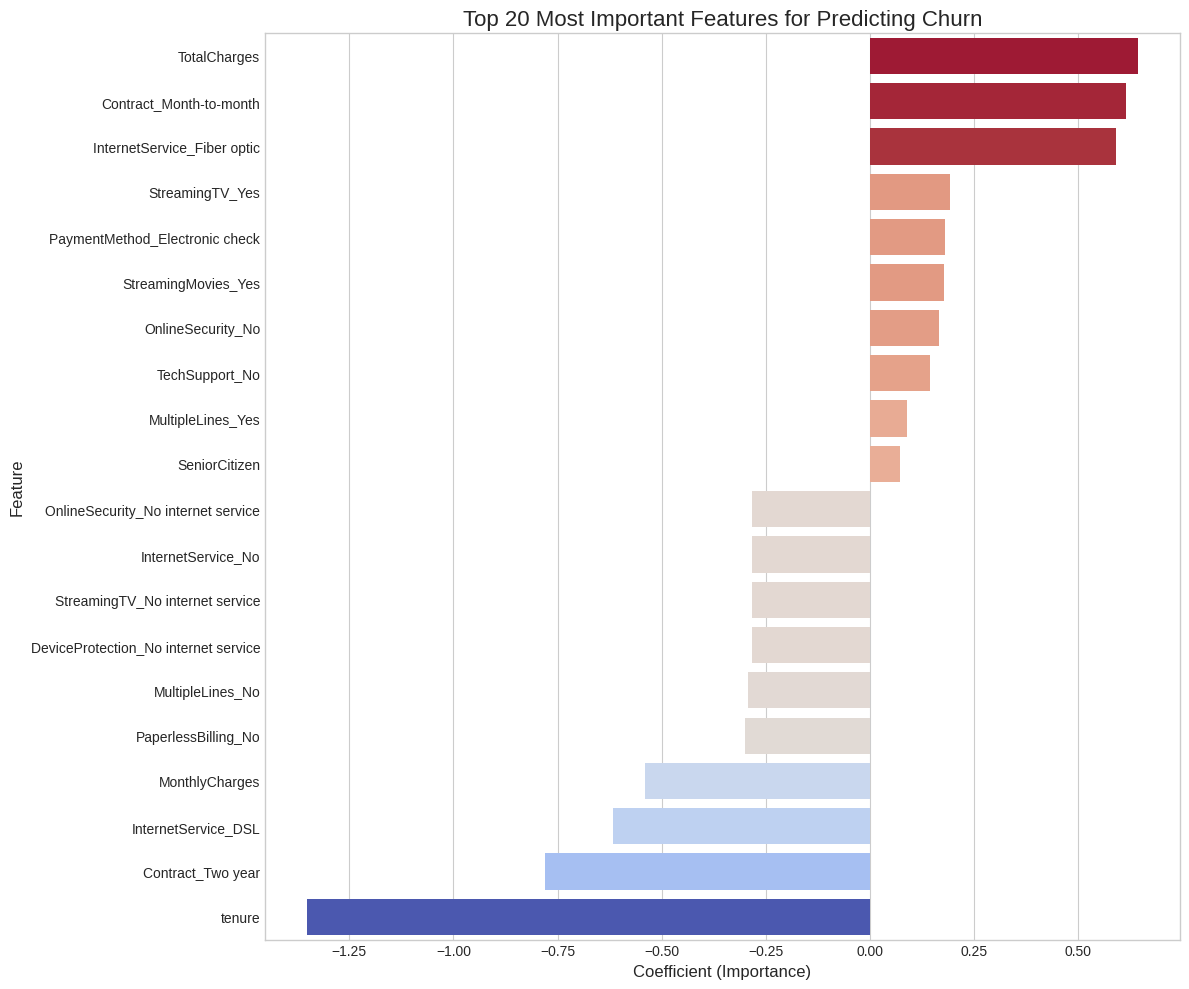

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize feature importance
plt.style.use('seaborn-v0_8-whitegrid')
top_and_bottom_10 = pd.concat([feature_importance.head(10), feature_importance.tail(10)])

# Add a dummy hue column to use with palette (fixes sns warning)
top_and_bottom_10['dummy_hue'] = top_and_bottom_10['Importance']

plt.figure(figsize=(12, 10))
sns.barplot(
    x='Importance',
    y='Feature',
    data=top_and_bottom_10,
    hue='dummy_hue',
    palette='coolwarm',
    dodge=False,
    legend=False
)
plt.title('Top 20 Most Important Features for Predicting Churn', fontsize=16)
plt.xlabel('Coefficient (Importance)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

## Least Important Features

I calculate the least important features to potentially prune them and simplify the model.

In [25]:
import numpy as np
# Calculate the absolute importance to find features closest to zero
feature_importance['Absolute_Importance'] = np.abs(feature_importance['Importance'])

# Sort by the absolute importance in ascending order
least_important_features = feature_importance.sort_values(by='Absolute_Importance', ascending=True)

print("Features ranked by their impact (least important first):")
# Display all features, starting with the least important
print(least_important_features.to_string())

Features ranked by their impact (least important first):
                                    Feature  Importance  Absolute_Importance
40                     PaperlessBilling_Yes   -0.009285             0.009285
26                     DeviceProtection_Yes    0.032693             0.032693
8                             Dependents_No   -0.039151             0.039151
21                          OnlineBackup_No    0.043639             0.043639
24                      DeviceProtection_No   -0.058642             0.058642
23                         OnlineBackup_Yes   -0.069587             0.069587
0                             SeniorCitizen    0.071011             0.071011
14                        MultipleLines_Yes    0.088164             0.088164
13           MultipleLines_No phone service   -0.104365             0.104365
10                          PhoneService_No   -0.104365             0.104365
44               PaymentMethod_Mailed check   -0.123531             0.123531
6                  

# Pruned Model

In [28]:
# Create a copy to avoid modifying the original DataFrame
data_pruned = data.copy()

# 1. Prune the unimportant features
features_to_drop = ['gender', 'PhoneService', 'Partner']
data_pruned.drop(columns=features_to_drop, inplace=True)
print(f"Dropped columns: {features_to_drop}\n")

# 2. Set up the new feature set and target variable
X_pruned = data_pruned.drop('Churn', axis=1)
y_pruned = data_pruned['Churn']

# Identify column types for the new, smaller dataset
categorical_features_pruned = X_pruned.select_dtypes(include=['object']).columns
numerical_features_pruned = X_pruned.select_dtypes(include=['int64', 'float64']).columns

# 3. Split the pruned data
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_pruned, y_pruned, test_size=0.2, random_state=42, stratify=y_pruned)

# 4. Define a new preprocessor and pipeline for the pruned data
preprocessor_pruned = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_pruned),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_pruned)
    ])

model_pruned = Pipeline(steps=[('preprocessor', preprocessor_pruned),
                               ('classifier', LogisticRegression(random_state=42, max_iter=1000))])

# 5. Train the new model
model_pruned.fit(X_train_p, y_train_p)

# 6. Evaluate the new model's performance
print("Classification Report:")
y_pred_p = model_pruned.predict(X_test_p)
print(classification_report(y_test_p, y_pred_p))

Dropped columns: ['gender', 'PhoneService', 'Partner']

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



## Save Model

In [29]:
# Save the trained pruned model
model_name = 'churn_model.joblib'
drive_path = f'/content/drive/My Drive/{model_name}'
# Uncomment this if you want the full model
#joblib.dump(model, drive_path)
joblib.dump(model_pruned, drive_path)
print(f"Best model saved to Google Drive at: {drive_path}")

Best model saved to Google Drive at: /content/drive/My Drive/churn_model.joblib
